# 修士論文実験 2022/01/25
## cross_validationのコード実装
## 正解データはスコアの得点
## データの水増し実装

In [42]:
import os
import sys
import csv
import math
import time
import json
import glob
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import interpolate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Subset
from torch.utils.tensorboard import SummaryWriter

from pytorchtools import EarlyStopping


%matplotlib inline


# sys.path.append(os.path.abspath(".."))
# import scripts.compensate
# import scripts.kinectImg2video
# from scripts.conpemsate_suppresser import *
# from scripts.ground_angle_analysis import ground_shoulder_angle_analyzer
# import scripts.ground_angle_analysis

In [43]:
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [44]:
# 日付の追加
df_annotate = pd.read_excel("annotate_dataset.xlsx")
df_annotate['date'] = pd.to_datetime(df_annotate['date'], format='%Y-%m-%d-%H-%M-%S')

In [45]:
df_annotate.head()

,date,uid,subject_id,task_id,point,shoulder,body,flag_usage
0,2021-12-06 18:56:20,1,1,1,3,0,0,1
1,2021-12-06 18:56:20,2,1,1,4,0,0,2
2,2021-12-06 18:56:41,3,1,1,3,0,0,1
3,2021-12-06 18:56:41,4,1,1,4,0,0,2
4,2021-12-06 18:56:58,5,1,1,3,0,0,1


In [46]:
# DataSetの呼び出し
df_data = pd.read_csv("bigdata_trimmed.csv")
df_data['date'] = pd.to_datetime(df_data['date'], format='%Y-%m-%d-%H-%M-%S')
df_data.head()

,Unnamed: 0,Unnamed: 0.1,id,x_Pelvis,y_Pelvis,z_Pelvis,x_SpineNaval,y_SpineNaval,z_SpineNaval,x_SpineChest,...,x_REar,y_REar,z_REar,N,v_RWrist,z_v_RWrist,flag_active,flag_moving,timestamp,date
0,0,0,1.0,-158.973129,353.261841,698.233093,-149.886017,218.100922,780.778748,-142.035919,...,-178.933960,-236.272278,842.268127,NaN,NaN,-0.917988,0.0,1.0,0.000000,2021-12-04 18:20:18
1,1,1,1.0,-156.911919,356.031863,697.378637,-147.957493,219.063530,781.238292,-142.348493,...,-176.788628,-241.853940,862.009244,NaN,7.131710,0.480634,1.0,1.0,39.891892,2021-12-04 18:20:18
2,2,2,1.0,-157.406120,356.970863,697.867036,-148.184343,219.214968,781.799317,-142.899719,...,-176.093690,-243.703880,867.831643,NaN,5.690953,0.198082,1.0,1.0,79.783784,2021-12-04 18:20:18
3,3,3,1.0,-159.493486,356.687710,699.214911,-149.753131,218.849632,782.412353,-143.553739,...,-176.457427,-243.071735,864.096621,NaN,6.280899,0.313779,1.0,1.0,119.675676,2021-12-04 18:20:18
4,4,4,1.0,-162.211771,355.791270,700.938883,-151.850422,218.261918,783.027933,-144.174692,...,-177.488121,-241.207140,855.165480,NaN,6.247976,0.307322,1.0,1.0,159.567568,2021-12-04 18:20:18


In [47]:
# pd_merged = pd.merge(df_annotate, df_data, on='date', how='inner')
# pd_3 = pd_merged[pd_merged['point'] == 3]
# pd_2A = pd_merged[pd_merged['point'] == '2A']
# pd_2B = pd_merged[pd_merged['point'] == '2B']
# pd_2C = pd_merged[pd_merged['point'] == '2C']

### このデータセットはGraspのものかつ，usageが1のものが取り出されている

In [48]:
# データセットにNN入力用のスコアを割り振る．
# これが正解ラベルになる
dataset = pd.merge(df_annotate, df_data, on='date', how='inner')

dataset = dataset[(dataset['task_id'] == 1) & (dataset['flag_usage'] == 1)]
dataset['point'] = dataset['point'].astype(str)
dataset.loc[dataset['point'] == '3', 'score'] = 3
dataset.loc[dataset['point'] == '2A', 'score'] = 2
dataset.loc[dataset['point'] == '2B', 'score'] = 1
dataset.loc[dataset['point'] == '2C', 'score'] = 0
print(dataset['score'].max())

# Nanのものを削除
dataset.dropna(subset=['score'], inplace=True)
# scoreの行をintにする
dataset['score'] = dataset['score'].astype(int)

3.0


In [49]:
dataset['uid'].unique()
# dataset['date'].unique().shape

array([ 1,  3,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98], dtype=int64)

In [50]:
# Grasp動作だけを抜き出す
# dataset_grasp = dataset[dataset['task_id'] == 1]

## RElbow2RWrist と Rshoulder2RElbow と Pelvis2RShoulder と Pelvis2Neck の速度を入れてみる 

In [51]:
# df_annotate
# l_date = df_annotate['date'].values

In [52]:
def add_vector(df, joint1, joint2, word=""):
    df[f"{word}_x_{joint1}2{joint2}"] = df[f"x_{joint1}"].astype('float64') - df[f"x_{joint2}"].astype('float64')
    df[f"{word}_y_{joint1}2{joint2}"] = df[f"y_{joint1}"].astype('float64') - df[f"y_{joint2}"].astype('float64')
    df[f"{word}_z_{joint1}2{joint2}"] = df[f"z_{joint1}"].astype('float64') - df[f"z_{joint2}"].astype('float64')
    df[f"{word}_ave_{joint1}2{joint2}"] = (df[f"{word}_x_{joint1}2{joint2}"] + df[f"{word}_y_{joint1}2{joint2}"] + df[f"{word}_z_{joint1}2{joint2}"])/3
    return df

def calc_angle(df, joint1, joint2, joint3):
    l_theta = []
    # 角度を算出する関数。p2を支点として、他の二点間の角度を算出する。
    x1, y1 ,z1= df[f"x_{joint1}"].astype('float64'), df[f"y_{joint1}"].astype('float64'), df[f"z_{joint1}"].astype('float64')
    x2, y2 ,z2= df[f"x_{joint2}"].astype('float64'), df[f"y_{joint2}"].astype('float64'), df[f"z_{joint2}"].astype('float64')
    x3, y3 ,z3= df[f"x_{joint3}"].astype('float64'), df[f"y_{joint3}"].astype('float64'), df[f"z_{joint3}"].astype('float64')
    v1 = np.array([x1-x2, y1-y2, z1-z2])
    v2 = np.array([x3-x2, y3-y2, z3-z2])
    for i in range(v1.shape[1]):
        cos = np.dot(v1[:,i], v2[:,i])/(np.linalg.norm(v1[:,i], ord=2) * np.linalg.norm(v2[:,i], ord=2))
        theta = np.degrees(math.acos(cos))
        l_theta.append(theta)
    return np.array(l_theta)

In [53]:
# 角度と角度の速度を入力とする
angle_RElbow = calc_angle(dataset, 'RShoulder', 'RElbow', 'RWrist')
diff_angle_RElbow = np.diff(angle_RElbow)

angle_RShoulder = calc_angle(dataset, 'RElbow', 'RShoulder', 'Neck')
diff_angle_RShoulder = np.diff(angle_RShoulder)

In [54]:
# l_date_name = np.array(dataset['date'].unique())
# l = []
# for date in l_date_name:
#     score = dataset[dataset["date"] == date]['score'].mode()
#     l.append(score)
# return np.array(l)

In [55]:
# 正解ラベルで用いるyのone hotベクトルを作成
def extract_y(df, augment_flag=False, rate_augment=10):
    l = []
    l_date_name = np.array(df['date'].unique())
    for date in l_date_name:
        score = df[df["date"] == date]['score'].mode()
        l.append(score)
        if augment_flag:
            for i in range(rate_augment):
                l.append(score)
    y = np.array(l).flatten()
    
    # l_date_name = np.array(df['date'].unique())
    # y = np.array(df["score"]) #一番多いものをscoreとして最後にyとして返す
    # y_arr = np.ones(l_date_name.shape)
    # y_arr = y_arr * y
    return y

def interpolate1(array, length=100):
    x_old = np.linspace(0, 1, array.shape[0])
    y_old = array
    
    f = interpolate.interp1d(x_old, y_old)

    x = np.linspace(0, 1, length)
    y_new = f(x)
    return y_new

def zscore(x, axis = 1):
    xmean = x.mean(axis=axis, keepdims=True)
    xstd  = np.std(x, axis=axis, keepdims=True)
    zscore = (x-xmean)/xstd
    return zscore

In [56]:
# Xの系列を入力とすると，rateのものを10倍作成して返す
def augmentation(arr_data, rate=0.8, num_arr=10, origin_length=100):
    #まず100個に補間 shape:(100, num_feature)
    interpolate = interpolate_one_sample(arr_data)
    interpolate = interpolate.reshape(interpolate.shape[1], -1)
    
    num_data = origin_length * rate #実際に用いるデータ点列
    
    for i in range(num_arr):
        first_idx = round( i/num_arr * origin_length * (1-rate))
        end_idx = round( i/num_arr * origin_length * (1-rate) + origin_length * rate )
        # print(f"first index is {first_idx}, end index is {end_idx}")
        one_trimmed = interpolate[first_idx:end_idx, :]
        one_arr = interpolate_one_sample(one_trimmed)
        if i == 0:
                x = one_arr #(1, 100, num_feature)
        else:
            x = np.concatenate([x, one_arr],0)
    return x # (num_arr, 100, num_feature)

In [57]:
def interpolate_one_sample(arr_data):
    num_feature = arr_data.shape[1]
    for i in range(num_feature):
            tmp_interpolate = interpolate1(arr_data[:, i])
            #3次元に拡張
            origin = tmp_interpolate.reshape(1, tmp_interpolate.shape[0], 1)
            
            if i == 0:
                x = origin
            else:
                # print(f"x shape is {x.shape}, ")
                x = np.concatenate([x, origin],2)
    return x #(1, 100, num_feature)

In [58]:
# この関数を実行しさえすればデータセットが作成される
def create_Xy(dataset, augment_flag=False, rate_augment=5, rate=0.9):
    #正解ラベルの作成
    y = extract_y(dataset, augment_flag, rate_augment=rate_augment)
    X = None
    
    # Xの作成
    l_date_name = np.array(dataset['date'].unique())
    for k, date in enumerate(l_date_name):
        #一連のデータ，1サンプル
        series = dataset[dataset['date'] == l_date_name[k]]
        series.drop(columns='point', inplace=True)
        series.drop(columns='date', inplace=True)
        #差分ベクトルを取得
        diff = series.diff()
        diff.fillna(0, inplace=True)

        # 間接点同士のベクトルのカラムをデータフレームに追加
        # これらがデータセットになる
        diff = add_vector(diff, 'RElbow', "RWrist", 'v')
        diff = add_vector(diff, 'RShoulder', "RElbow", 'v')
        diff = add_vector(diff, 'Pelvis', "RShoulder", 'v')
        diff = add_vector(diff, 'Pelvis', "Neck", 'v')
        diff = add_vector(diff, 'Neck', 'RShoulder', 'v')
        diff = add_vector(diff, 'Neck', 'LShoulder', 'v')
        
        # 1サンプルに関するデータ shape = (num_timestep, num_feature)
        arr_data = diff.loc[:, "v_x_RElbow2RWrist":].values
        
        origin = interpolate_one_sample(arr_data)
        
        # augmentで増やす
        # この関数の出力 (augmented_num, 100, num_feature)
        if augment_flag:
            augmented_arr = augmentation(arr_data, rate=rate, num_arr=rate_augment)
            augmented_origin_arr = np.concatenate([origin, augmented_arr], 0)
        else:
            augmented_origin_arr = origin
                
        #最初だけ条件分岐
        if k == 0:
            out = augmented_origin_arr
        else:
            out = np.concatenate([out, augmented_origin_arr], axis=0)     
    # 最後にzscore変換
        # print(X.shape)
    X = zscore(out)
    return X, y

## Build the model

Our model processes a tensor of shape `(batch size, sequence length, features)`,
where `sequence length` is the number of time steps and `features` is each input
timeseries.

You can replace your classification RNN layers with this one: the
inputs are fully compatible!

We include residual connections, layer normalization, and dropout.
The resulting layer can be stacked multiple times.

The projection layers are implemented through `keras.layers.Conv1D`.

In [59]:
class PositionalEncoder(nn.Module):
    '''入力された単語の位置を示すベクトル情報を付加する'''

    def __init__(self, d_model=12, max_seq_len=256):
        super().__init__()

        self.d_model = d_model  # 単語ベクトルの次元数

        # 単語の順番（pos）と埋め込みベクトルの次元の位置（i）によって一意に定まる値の表をpeとして作成
        pe = torch.zeros(max_seq_len, d_model)

        # GPUが使える場合はGPUへ送る、ここでは省略。実際に学習時には使用する
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        pe = pe.to(device)

        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/d_model)))
                
                # 誤植修正_200510 #79
                # pe[pos, i + 1] = math.cos(pos /
                #                          (10000 ** ((2 * (i + 1))/d_model)))
                pe[pos, i + 1] = math.cos(pos /
                                          (10000 ** ((2 * i)/d_model)))

        # 表peの先頭に、ミニバッチ次元となる次元を足す
        self.pe = pe.unsqueeze(0)

        # 勾配を計算しないようにする
        self.pe.requires_grad = False

    def forward(self, x):
        # 入力xとPositonal Encodingを足し算する
        # xがpeよりも小さいので、大きくする
        ret = math.sqrt(self.d_model)*x + self.pe
        return ret


In [60]:
class Attention(nn.Module):
    def __init__(self, d_model=4):
        super().__init__()

        # SAGANでは1dConvを使用したが、今回は全結合層で特徴量を変換する
        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)

        # 出力時に使用する全結合層
        self.out = nn.Linear(d_model, d_model)

        # Attentionの大きさ調整の変数
        self.d_k = d_model

    def forward(self, q, k, v, mask):
        # 全結合層で特徴量を変換
        k = self.k_linear(k)
        q = self.q_linear(q)
        v = self.v_linear(v)

        # Attentionの値を計算する
        # 各値を足し算すると大きくなりすぎるので、root(d_k)で割って調整
        weights = torch.matmul(q, k.transpose(1, 2)) / math.sqrt(self.d_k)

        # ここでmaskを計算
        # mask = mask.unsqueeze(1)
        # print(mask)
        # weights = weights.masked_fill(mask == 0, -1e9)

        # softmaxで規格化をする
        normlized_weights = F.softmax(weights, dim=-1)

        # AttentionをValueとかけ算
        output = torch.matmul(normlized_weights, v)

        # 全結合層で特徴量を変換
        output = self.out(output)

        return output, normlized_weights


In [61]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=1024, dropout=0.1):
        '''Attention層から出力を単純に全結合層2つで特徴量を変換するだけのユニットです'''
        super().__init__()

        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        x = self.linear_1(x)
        x = self.dropout(F.relu(x))
        x = self.linear_2(x)
        return x

In [62]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model=4, dropout=0.1):
        super().__init__()

        # LayerNormalization層
        # https://pytorch.org/docs/stable/nn.html?highlight=layernorm
        self.norm_1 = nn.LayerNorm(d_model)
        self.norm_2 = nn.LayerNorm(d_model)

        # Attention層
        self.attn = Attention(d_model)

        # Attentionのあとの全結合層2つ
        self.ff = FeedForward(d_model)

        # Dropout
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)

    def forward(self, x, mask):
        # 正規化とAttention
        # print(f"input shape is {x.shape}")
        x_normlized = self.norm_1(x)
        output, attn_weights = self.attn(x_normlized, x_normlized, x_normlized, mask)
        
        x2 = x + self.dropout_1(output)

        # 正規化と全結合層
        x_normlized2 = self.norm_2(x2)
        output = x2 + self.dropout_2(self.ff(x_normlized2))
        # print(f"output shape is {output.shape}")

        return output, attn_weights


In [63]:
class ScoringHead(nn.Module):
    '''Transformer_Blockの出力を使用して，最後にスコアリングを行う'''
    
    def __init__(self, d_model=300, output_dim=1):
        super().__init__()

        # 全結合層
        self.linear = nn.Linear(d_model, output_dim)  # output_dimはポジ・ネガの2つ
        self.output_dim = output_dim

        # 重み初期化処理
        nn.init.normal_(self.linear.weight, std=0.02)
        nn.init.normal_(self.linear.bias, 0)

    def forward(self, x):
        x0 = x[:, 0, :]  # 各ミニバッチの各文の先頭の単語の特徴量（300次元）を取り出す
        weights = self.linear.weight
        out = self.linear(x0)
        
        # print(f"Scoring input shape is {x0.shape}")
        # print(f"Scoring weight shape is {weights.shape}")
        # print(f"Scoring output shape is {out.shape}")

        return out, weights

In [64]:
# class ClassificationHead(nn.Module):
#     '''Transformer_Blockの出力を使用し、最後にクラス分類させる'''

#     def __init__(self, d_model=300, output_dim=4):
#         super().__init__()

#         # 全結合層
#         self.linear = nn.Linear(d_model, output_dim)  # output_dimはポジ・ネガの2つ
#         self.output_dim = output_dim

#         # 重み初期化処理
#         nn.init.normal_(self.linear.weight, std=0.02)
#         nn.init.normal_(self.linear.bias, 0)

#     def forward(self, x):
#         x0 = x[:, 0, :]  # 各ミニバッチの各文の先頭の単語の特徴量（300次元）を取り出す
#         x1 = self.linear(x0)
#         # print(x1.shape)
#         out = F.softmax(x1, dim=-1)

#         return out


# ここで複数入力のAttentionにする

In [65]:
# # 最終的なTransformerモデルのクラス

# class TransformerClassification(nn.Module):
#     '''Transformerでクラス分類させる'''

#     def __init__(self, d_model=12, max_seq_len=101, output_dim=4):
#         super().__init__()

#         # モデル構築
#         self.net_Positional = PositionalEncoder(d_model=d_model, max_seq_len=max_seq_len)
        
#         self.net_Attention_1 = TransformerBlock(d_model=4)
#         self.net_Attention_2 = TransformerBlock(d_model=4)
#         self.net_Attention_3 = TransformerBlock(d_model=4)
#         self.net_Attention_4 = TransformerBlock(d_model=4)
#         self.net_Attention_5 = TransformerBlock(d_model=4)
#         self.net_Attention_6 = TransformerBlock(d_model=4)
        
#         self.net_Attention_all = TransformerBlock(d_model=24)
#         # self.net3_2 = TransformerBlock(d_model=d_model)
        
#         self.net_Classification = ClassificationHead(output_dim=output_dim, d_model=d_model)

#     def forward(self, x, mask):
#         x = self.net_Positional(x)  # Positon情報を足し算
#         #ここでいくつのAttentionアーキテクチャを利用するか決定する
#         # num_attention_block = x.shape[2]/4
        
#         x1, attn_weights_1 = self.net_Attention_1(x[:,:,0:4], mask[:,:,0:4])  # Self-Attentionで特徴量を変換
#         x2, attn_weights_2 = self.net_Attention_2(x[:,:,4:8], mask[:,:,4:8])
#         x3, attn_weights_3 = self.net_Attention_3(x[:,:,8:12], mask[:,:,8:12])
#         x4, attn_weights_4 = self.net_Attention_4(x[:,:,12:16], mask[:,:,12:16])
#         x5, attn_weights_5 = self.net_Attention_5(x[:,:,16:20], mask[:,:,16:20])
#         x6, attn_weights_6 = self.net_Attention_6(x[:,:,20:24], mask[:,:,20:24])
        
#         #出力を全部つなぎ合わせる
#         x_concat = torch.cat((x1,x2,x3,x4,x5,x6), 2)
#         # x_attn, attn_weights_all = self.net_Attention_all(x_concat, mask)
        
#         x_out = self.net_Classification(x_concat)  # 最終出力の0単語目を使用して、分類0-1のスカラーを出力
        
#         l_attn_weights = [attn_weights_1,attn_weights_2,attn_weights_3,attn_weights_4,attn_weights_5,attn_weights_6
#                           # , attn_weights_all
#                          ] 
#         return x_out, l_attn_weights


In [66]:
# 最終的なTransformerモデルのクラス

class TransformerScoring(nn.Module):
    '''Transformerでクラス分類させる'''

    def __init__(self, d_model=12, max_seq_len=101, output_dim=4):
        super().__init__()

        # モデル構築
        self.net_Positional = PositionalEncoder(d_model=d_model, max_seq_len=max_seq_len)
        
        self.net_Attention_1 = TransformerBlock(d_model=4)
        self.net_Attention_2 = TransformerBlock(d_model=4)
        self.net_Attention_3 = TransformerBlock(d_model=4)
        self.net_Attention_4 = TransformerBlock(d_model=4)
        self.net_Attention_5 = TransformerBlock(d_model=4)
        self.net_Attention_6 = TransformerBlock(d_model=4)
        
        self.net_Attention_all = TransformerBlock(d_model=24)
        # self.net3_2 = TransformerBlock(d_model=d_model)
        
        # self.net_Classification = ClassificationHead(output_dim=output_dim, d_model=d_model)
        self.net_Scoring = ScoringHead(output_dim=output_dim, d_model=d_model)

    def forward(self, x, mask):
        x = self.net_Positional(x)  # Positon情報を足し算
        #ここでいくつのAttentionアーキテクチャを利用するか決定する
        # num_attention_block = x.shape[2]/4
        
        x1, attn_weights_1 = self.net_Attention_1(x[:,:,0:4], mask[:,:,0:4])  # Self-Attentionで特徴量を変換
        x2, attn_weights_2 = self.net_Attention_2(x[:,:,4:8], mask[:,:,4:8])
        x3, attn_weights_3 = self.net_Attention_3(x[:,:,8:12], mask[:,:,8:12])
        x4, attn_weights_4 = self.net_Attention_4(x[:,:,12:16], mask[:,:,12:16])
        x5, attn_weights_5 = self.net_Attention_5(x[:,:,16:20], mask[:,:,16:20])
        x6, attn_weights_6 = self.net_Attention_6(x[:,:,20:24], mask[:,:,20:24])
        
        #出力を全部つなぎ合わせる
        x_concat = torch.cat((x1,x2,x3,x4,x5,x6), 2)
        x_attn, attn_weights_all = self.net_Attention_all(x_concat, mask)
        x_out, _ = self.net_Scoring(x_attn)        
        # x_out, _ = self.net_Scoring(x_concat)  # 最終出力の0単語目を使用して、分類0-1のスカラーを出力
        
        l_attn_weights = [attn_weights_1,attn_weights_2,attn_weights_3,attn_weights_4,attn_weights_5,attn_weights_6
                          , attn_weights_all
                         ] 
        return x_out, l_attn_weights


# validation用に1人のデータを検証データに回す

In [67]:
# train_df = dataset
# [~(dataset['subject_id'] == 4)]
# val_df = dataset[dataset['subject_id'] == 4]

## PyTorchのdatasetの作成


In [68]:
# x_train, y_train = create_Xy(train_df, augment_flag=True, rate_augment=5, rate=0.95)
# x_test, y_test = create_Xy(val_df, augment_flag=True, rate_augment=5, rate=0.95)

# y_train = y_train.astype('int64')
# y_test = y_test.astype('int64')


# 正解データをone hotベクトルに変換
# n_classes = len(np.unique(y_train))
# y_train_onehot = np.identity(n_classes)[y_train]
# y_test_onehot = np.identity(n_classes)[y_test]


# ### 先頭にclassification用のトークンを追加する
# score_train = np.zeros((x_train.shape[0], 1 , x_train.shape[2]))
# x_train = np.concatenate([score_train, x_train], axis=1)

# score_test = np.zeros((x_test.shape[0], 1 , x_test.shape[2]))
# x_test = np.concatenate([score_test, x_test], axis=1)

In [69]:
# ### 先頭にclassification用のトークンを追加する
# score_train = np.zeros((x_train.shape[0], 1 , x_train.shape[2]))
# x_train = np.concatenate([score_train, x_train], axis=1)

# score_test = np.zeros((x_test.shape[0], 1 , x_test.shape[2]))
# x_test = np.concatenate([score_test, x_test], axis=1)

## Train and evaluate

In [70]:
# # 動作確認
# # ミニバッチの用意
# batch = next(iter(train_dataloader))

# # モデル構築

# # 変数の固定
# torch.manual_seed(1234)
# torch.cuda.manual_seed(1234)

# net = TransformerScoring(
#     d_model=24, max_seq_len=101, output_dim=1)

# # 入出力
# _device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# net.to(_device)
# x = batch[0].to(_device)
# input_pad = 1
# input_mask = (x != input_pad)
# out, l_weights = net(x, input_mask)

# print("出力のテンソルサイズ：", out.shape)
# # print("出力テンソル", out)
# # print("出力テンソルのsigmoid：", F.softmax(out, dim=1))


The main part of our model is now complete. We can stack multiple of those
`transformer_encoder` blocks and we can also proceed to add the final
Multi-Layer Perceptron classification head. Apart from a stack of `Dense`
layers, we need to reduce the output tensor of the `TransformerEncoder` part of
our model down to a vector of features for each data point in the current
batch. A common way to achieve this is to use a pooling layer. For
this example, a `GlobalAveragePooling1D` layer is sufficient.

In [71]:
# # ネットワークの初期化を定義

# def weights_init(m):
#     classname = m.__class__.__name__
#     if classname.find('Linear') != -1:
#         # Liner層の初期化
#         nn.init.kaiming_normal_(m.weight)
#         if m.bias is not None:
#             nn.init.constant_(m.bias, 0.0)

# # 訓練モードに設定
# net.train()

# # TransformerBlockモジュールを初期化実行

# net.net_Attention_1.apply(weights_init)



# print('ネットワーク設定完了')

In [72]:
# 損失関数の設定
# # criterion = nn.CrossEntropyLoss()
# criterion = nn.MSELoss()
# # nn.LogSoftmax()を計算してからnn.NLLLoss(negative log likelihood loss)を計算

# # 最適化手法の設定
# learning_rate = 3e-4
# optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [73]:
# モデルを学習させる関数を作成
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs, patience, label):
    # Early Stopping を定義
    early_stopping = EarlyStopping(patience=patience, label=label)

    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)
    print('-----start-------')
    # ネットワークをGPUへ
    net.to(device)

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

    # epochのループ
    flag = False
    for epoch in range(num_epochs):
        # epochごとの訓練と検証のループ
        for phase in ['train', 'val']:
        # for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # データローダーからミニバッチを取り出すループ
            for batch in (dataloaders_dict[phase]):
                # batchはTextとLableの辞書オブジェクト

                # GPUが使えるならGPUにデータを送る
                inputs = batch[0].to(device)  # 文章
                labels = batch[1].to(device)  # ラベル

                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):

                    # mask作成
                    input_pad = 1  # 単語のIDにおいて、'<pad>': 1 なので
                    input_mask = (inputs != input_pad)

                    # Transformerに入力
                    outputs, _ = net(inputs, input_mask)
                    _, labels_true = torch.max(labels.data, 1)  # ワンホットラベルを平坦化
                    labels_true_float = labels_true.float()
                    # print(type(labels_true_float.dtype))
                    # print(f"outputs shape is {outputs.flatten().shape}, label shape is {labels_true.shape}")
                    outputs = outputs.flatten()
                    loss = criterion(outputs, labels_true_float)  # 損失を計算
                    # print(f"output is {outputs}, labels float are {labels_true_float}")

                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # 結果の計算
                    # print(np.array(preds))
                    # print(np.array(np.argmax(labels.data)))
                    # print(preds == labels.data)
                    epoch_loss += loss.item() * inputs.size(0)  # lossの合計を更新
                    # 正解数の合計を更新
                    
                    # one_hot=F.one_hot(preds,num_classes=4)
                    # epoch_corrects += torch.sum(preds == labels_true)
                    # print(labels_true)
                    # print(torch.flatten(preds))
                    preds = torch.round(outputs)  # ラベルを予測
                    # print(f"predicts are {preds}, labels {labels_true}")
                    # print(preds == labels_true)
                    epoch_corrects += torch.sum(preds == labels_true)

            # epochごとのlossと正解率
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
            
            
            if epoch % 100 == 0:
                print('Epoch {}/{} | {:^5} |  Loss: {:.4f} Acc: {:.4f}'.format(epoch+1, num_epochs,
                                                                           phase, epoch_loss, epoch_acc))
                # print(f"epoch corrects {epoch_corrects.double()}")
                # print(f"dataset size = {len(dataloaders_dict[phase].dataset)}")
                
            if phase == 'train':
                writer.add_scalar("Loss/train", loss, epoch)

            else:
                writer.add_scalar("Loss/test", loss, epoch)
                early_stopping(loss, net) # 最良モデルならモデルパラメータ保存
                if early_stopping.early_stop: 
                # 一定epochだけval_lossが最低値を更新しなかった場合、ここに入り学習を終了
                    print(f"Early Stopping!! Epoch {epoch+1}/{num_epochs} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} :: {epoch_corrects.double()}/{len(dataloaders_dict[phase].dataset)}")
                    flag = True
        if flag:
            break

    return net, epoch_loss, epoch_acc


In [ ]:
# #損失関数
# criterion = nn.MSELoss()
# num_epochs = 1000
# patience = 100
# batch_size = 32

# n_classes = 4

# # グリッドサーチを行う．
# l_rate = [1e-5, 1e-4, 1e-3, 1e-2]
# # l_rate = [1e-3]

# seeds = [1000]
# seed = 1000
# # for i in range(15):
# #     seeds.append(1000+i)


# for seed in seeds:
#     print("---------------------------------------------------------------------------------")
#     print(f"seed is {seed}")
#     # 変数の固定
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     np.random.seed(seed)
    
#     for learning_rate in l_rate:

#         # kf = KFold(n_splits=5, shuffle=True, random_state=2022)
#         cv_loss = 0
#         cv_acc = 0

#         for subject_id in range(n_classes): 
#             print("---------------------------------------------------------------------------------")
#             print(f"test subject id : {subject_id+1}")
#             train_df = dataset[~(dataset['subject_id'] == (subject_id+1))]
#             val_df = dataset[dataset['subject_id'] == (subject_id+1)]

#             x_train, y_train = create_Xy(train_df, augment_flag=True, rate_augment=5, rate=0.95)
#             x_test, y_test = create_Xy(val_df, augment_flag=True, rate_augment=5, rate=0.95)

#             ### 先頭にclassification用のトークンを追加する
#             score_train = np.zeros((x_train.shape[0], 1 , x_train.shape[2]))
#             x_train = np.concatenate([score_train, x_train], axis=1)
#             score_test = np.zeros((x_test.shape[0], 1 , x_test.shape[2]))
#             x_test = np.concatenate([score_test, x_test], axis=1)
#             y_train_onehot = np.identity(n_classes)[y_train]
#             y_test_onehot = np.identity(n_classes)[y_test]

#             train_dataset = torch.utils.data.TensorDataset(torch.tensor(x_train, dtype=torch.float32)
#                                                        , torch.tensor(y_train_onehot, dtype=torch.int8))
#             val_dataset = torch.utils.data.TensorDataset(torch.tensor(x_test, dtype=torch.float32),
#                                                          torch.tensor(y_test_onehot, dtype=torch.int8))
#             train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
#             val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False)
#             dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

#             writer = SummaryWriter()
#             print(f"learning_rate is {learning_rate}")

#             # モデル構築
#             net = TransformerScoring(d_model=24, max_seq_len=101, output_dim=1)
#             # 訓練モードに設定
#             net.train()
#             optimizer = optim.Adam(net.parameters(), lr=learning_rate)
#             start = time.time() #時間計測スタート
#             net_trained, loss, acc= train_model(net, 
#                                       dataloaders_dict,
#                                       criterion,
#                                       optimizer,
#                                       num_epochs,
#                                       patience
#                                      )
#             print(time.time() - start)
#             writer.flush()
#             cv_loss += loss / n_classes
#             cv_acc += acc /n_classes
#         print(f"cv_acc is {cv_acc}")

In [ ]:
# とりあえずvalidationがうまく動くかを確認

uid = dataset["uid"].unique()
x_all, y_all = create_Xy(dataset, augment_flag=False)
n_classes = len(np.unique(y_all))

#損失関数
criterion = nn.MSELoss()
num_epochs = 1000
patience = 100
batch_size = 8

# グリッドサーチを行う．
l_rate = [1e-4]
# l_rate = [1e-3]

seeds = [1002, 1004, 1005, 1006, 1007, 1008, 1009, 1010]
seed = 1000
# for i in range(15):
#     seeds.append(1000+i)

# 変数の固定
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

skf = StratifiedKFold(n_splits=10, shuffle=True,random_state=2022)

for seed in seeds:
    
    for learning_rate in l_rate:
        print("---------------------------------------------------------------------------------")
        cv = 0
        for _fold, (train_index, test_index) in enumerate(skf.split(x_all, y_all)):  
            
            train_df = dataset[dataset["uid"].isin(uid[train_index])]
            val_df = dataset[dataset["uid"].isin(uid[test_index])]
            # print(train_df["uid"].unique())
            # print(val_df["uid"].unique())

            x_train, y_train = create_Xy(train_df, augment_flag=True, rate_augment=5, rate=0.95)
            x_test, y_test = create_Xy(val_df, augment_flag=True, rate_augment=5, rate=0.95)

            ### 先頭にclassification用のトークンを追加する
            score_train = np.zeros((x_train.shape[0], 1 , x_train.shape[2]))
            x_train = np.concatenate([score_train, x_train], axis=1)
            score_test = np.zeros((x_test.shape[0], 1 , x_test.shape[2]))
            x_test = np.concatenate([score_test, x_test], axis=1)
            y_train_onehot = np.identity(n_classes)[y_train]
            y_test_onehot = np.identity(n_classes)[y_test]

            train_dataset = torch.utils.data.TensorDataset(torch.tensor(x_train, dtype=torch.float32)
                                                       , torch.tensor(y_train_onehot, dtype=torch.int8))
            val_dataset = torch.utils.data.TensorDataset(torch.tensor(x_test, dtype=torch.float32),
                                                         torch.tensor(y_test_onehot, dtype=torch.int8))
            train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
            val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False)
            dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}
            
            

            writer = SummaryWriter()
            print(f"seed is {seed}")
            print(f"learning_rate is {learning_rate}")

            # モデル構築
            net = TransformerScoring(d_model=24, max_seq_len=101, output_dim=1)
            # 訓練モードに設定
            net.train()
            optimizer = optim.Adam(net.parameters(), lr=learning_rate)
            start = time.time() #時間計測スタート
            net_trained, loss , acc = train_model(net, 
                                      dataloaders_dict,
                                      criterion,
                                      optimizer,
                                      num_epochs,
                                      patience,
                                      str(_fold)
                                     )
            print(time.time() - start)
            writer.flush()
            cv += acc / skf.n_splits
        # torch.save(model.state_dict(), f"models/crossvalidation_{_fold}.pth")
        print(f"k fold accuracy:{cv}")

In [76]:
# とりあえずvalidationがうまく動くかを確認

uid = dataset["uid"].unique()
x_all, y_all = create_Xy(dataset, augment_flag=False)
n_classes = len(np.unique(y_all))

#損失関数
criterion = nn.MSELoss()
num_epochs = 1000
patience = 100
batch_size = 16

# グリッドサーチを行う．
l_rate = [1e-4, 5e-4, 1e-3]
# l_rate = [1e-3]

# seeds = [1002, 1004, 1005, 1006, 1007, 1008, 1009, 1010]
seeds = [1002]
seed = 1000
# for i in range(15):
#     seeds.append(1000+i)

# 変数の固定
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=8888)

for seed in seeds:
    
    for learning_rate in l_rate:
        print("---------------------------------------------------------------------------------")
        cv = 0
        for _fold, (train_index, test_index) in enumerate(skf.split(x_all, y_all)):  
            
            train_df = dataset[dataset["uid"].isin(uid[train_index])]
            val_df = dataset[dataset["uid"].isin(uid[test_index])]
            # print(train_df["uid"].unique())
            # print(val_df["uid"].unique())

            x_train, y_train = create_Xy(train_df, augment_flag=True, rate_augment=5, rate=0.95)
            x_test, y_test = create_Xy(val_df, augment_flag=True, rate_augment=5, rate=0.95)

            ### 先頭にclassification用のトークンを追加する
            score_train = np.zeros((x_train.shape[0], 1 , x_train.shape[2]))
            x_train = np.concatenate([score_train, x_train], axis=1)
            score_test = np.zeros((x_test.shape[0], 1 , x_test.shape[2]))
            x_test = np.concatenate([score_test, x_test], axis=1)
            y_train_onehot = np.identity(n_classes)[y_train]
            y_test_onehot = np.identity(n_classes)[y_test]

            train_dataset = torch.utils.data.TensorDataset(torch.tensor(x_train, dtype=torch.float32)
                                                       , torch.tensor(y_train_onehot, dtype=torch.int8))
            val_dataset = torch.utils.data.TensorDataset(torch.tensor(x_test, dtype=torch.float32),
                                                         torch.tensor(y_test_onehot, dtype=torch.int8))
            train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
            val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False)
            dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}
            
            

            writer = SummaryWriter()
            print(f"seed is {seed}")
            print(f"learning_rate is {learning_rate}")

            # モデル構築
            net = TransformerScoring(d_model=24, max_seq_len=101, output_dim=1)
            # 訓練モードに設定
            net.train()
            optimizer = optim.Adam(net.parameters(), lr=learning_rate)
            start = time.time() #時間計測スタート
            net_trained, loss , acc = train_model(net, 
                                      dataloaders_dict,
                                      criterion,
                                      optimizer,
                                      num_epochs,
                                      patience,
                                      str(_fold)
                                     )
            print(time.time() - start)
            writer.flush()
            cv += acc / skf.n_splits
        # torch.save(model.state_dict(), f"models/crossvalidation_{_fold}.pth")
        print(f"k fold accuracy:{cv}")

---------------------------------------------------------------------------------


C:\Users\suzuk\anaconda3\envs\torch\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


seed is 1002
learning_rate is 0.0001
使用デバイス： cuda:0
-----start-------
Epoch 1/1000 | train |  Loss: 9.6657 Acc: 0.0000
Epoch 1/1000 |  val  |  Loss: 8.6948 Acc: 0.0000
Epoch 101/1000 | train |  Loss: 0.1195 Acc: 0.8468
Epoch 101/1000 |  val  |  Loss: 0.8322 Acc: 0.4333
Early Stopping!! Epoch 104/1000 Loss: 0.8327 Acc: 0.4000 :: 24.0/60
36.35074043273926
seed is 1002
learning_rate is 0.0001
使用デバイス： cuda:0
-----start-------
Epoch 1/1000 | train |  Loss: 9.3877 Acc: 0.0000
Epoch 1/1000 |  val  |  Loss: 8.6813 Acc: 0.0000
Epoch 101/1000 | train |  Loss: 0.1035 Acc: 0.8964
Epoch 101/1000 |  val  |  Loss: 1.7600 Acc: 0.1167
Early Stopping!! Epoch 105/1000 Loss: 1.6688 Acc: 0.1000 :: 6.0/60
35.703280448913574
seed is 1002
learning_rate is 0.0001
使用デバイス： cuda:0
-----start-------
Epoch 1/1000 | train |  Loss: 5.3753 Acc: 0.0965
Epoch 1/1000 |  val  |  Loss: 4.7818 Acc: 0.2222
Epoch 101/1000 | train |  Loss: 0.0915 Acc: 0.8904
Epoch 101/1000 |  val  |  Loss: 1.2589 Acc: 0.5000
Early Stopping!! E

C:\Users\suzuk\anaconda3\envs\torch\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


seed is 1002
learning_rate is 0.0005
使用デバイス： cuda:0
-----start-------
Epoch 1/1000 | train |  Loss: 1.2304 Acc: 0.2838
Epoch 1/1000 |  val  |  Loss: 1.4426 Acc: 0.2000
Epoch 101/1000 | train |  Loss: 0.0286 Acc: 0.9955
Epoch 101/1000 |  val  |  Loss: 1.3540 Acc: 0.2000
Early Stopping!! Epoch 143/1000 Loss: 1.4648 Acc: 0.1833 :: 11.0/60
49.469627141952515
seed is 1002
learning_rate is 0.0005
使用デバイス： cuda:0
-----start-------
Epoch 1/1000 | train |  Loss: 11.5775 Acc: 0.0000
Epoch 1/1000 |  val  |  Loss: 5.8176 Acc: 0.0000
Epoch 101/1000 | train |  Loss: 0.0406 Acc: 0.9640
Epoch 101/1000 |  val  |  Loss: 2.0865 Acc: 0.5333
Early Stopping!! Epoch 103/1000 Loss: 1.9940 Acc: 0.4833 :: 29.0/60
35.455079555511475
seed is 1002
learning_rate is 0.0005
使用デバイス： cuda:0
-----start-------
Epoch 1/1000 | train |  Loss: 1.6064 Acc: 0.2325
Epoch 1/1000 |  val  |  Loss: 1.2173 Acc: 0.3333
Epoch 101/1000 | train |  Loss: 0.0253 Acc: 0.9956
Epoch 101/1000 |  val  |  Loss: 1.1620 Acc: 0.3889
Early Stopping!

C:\Users\suzuk\anaconda3\envs\torch\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


seed is 1002
learning_rate is 0.001
使用デバイス： cuda:0
-----start-------
Epoch 1/1000 | train |  Loss: 2.8858 Acc: 0.1892
Epoch 1/1000 |  val  |  Loss: 2.1520 Acc: 0.2000
Epoch 101/1000 | train |  Loss: 0.0219 Acc: 0.9955
Epoch 101/1000 |  val  |  Loss: 0.7818 Acc: 0.4000
Epoch 201/1000 | train |  Loss: 0.0168 Acc: 0.9955
Epoch 201/1000 |  val  |  Loss: 0.7830 Acc: 0.3500
Early Stopping!! Epoch 239/1000 Loss: 0.7623 Acc: 0.3667 :: 22.0/60
82.30905818939209
seed is 1002
learning_rate is 0.001
使用デバイス： cuda:0
-----start-------
Epoch 1/1000 | train |  Loss: 1.9837 Acc: 0.2072
Epoch 1/1000 |  val  |  Loss: 1.5378 Acc: 0.2000
Epoch 101/1000 | train |  Loss: 0.0130 Acc: 1.0000
Epoch 101/1000 |  val  |  Loss: 1.1651 Acc: 0.2667
Early Stopping!! Epoch 107/1000 Loss: 1.1480 Acc: 0.2833 :: 17.0/60
36.91885018348694
seed is 1002
learning_rate is 0.001
使用デバイス： cuda:0
-----start-------
Epoch 1/1000 | train |  Loss: 1.3339 Acc: 0.2632
Epoch 1/1000 |  val  |  Loss: 1.2635 Acc: 0.2222
Epoch 101/1000 | trai

In [ ]:
all_df = dataset

x_all, y_all = create_Xy(all_df, augment_flag=False, rate_augment=5, rate=0.95)

# 正解データをone hotベクトルに変換
n_classes = len(np.unique(y_all))
y_all_onehot = np.identity(n_classes)[y_all]

### 先頭にclassification用のトークンを追加する
score_train = np.zeros((x_all.shape[0], 1 , x_all.shape[2]))
x_all = np.concatenate([score_train, x_all], axis=1)

dataset_all = torch.utils.data.TensorDataset(torch.tensor(x_all, dtype=torch.float32)
                                               , torch.tensor(y_all_onehot, dtype=torch.int8))


#損失関数
criterion = nn.MSELoss()
num_epochs = 1000
patience = 100
batch_size = 8

# グリッドサーチを行う．
l_rate = [5e-4]
# l_rate = [1e-3]

seeds = [1000]
seed = 1000
# for i in range(15):
#     seeds.append(1000+i)

# 変数の固定
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

train_index, valid_index = train_test_split(range(len(dataset_all)), test_size=0.2)

for seed in seeds:
    kf = KFold(n_splits=5, shuffle=True, random_state=2022)
    for learning_rate in l_rate:
        print("---------------------------------------------------------------------------------")
        cv = 0
        for _fold, (train_index, test_index) in enumerate(kf.split(dataset_all)):  
            
            train_dataset = Subset(dataset_all, train_index)
            train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
            val_dataset = Subset(dataset_all, valid_index)
            val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False)
            dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

            print(f"seed is {seed}")

            writer = SummaryWriter()
            print(f"learning_rate is {learning_rate}")

            # モデル構築
            net = TransformerScoring(d_model=24, max_seq_len=101, output_dim=1)
            # 訓練モードに設定
            net.train()
            optimizer = optim.Adam(net.parameters(), lr=learning_rate)
            start = time.time() #時間計測スタート
            net_trained, loss , acc = train_model(net, 
                                      dataloaders_dict,
                                      criterion,
                                      optimizer,
                                      num_epochs,
                                      patience
                                     )
            print(time.time() - start)
            writer.flush()
            cv += acc / kf.n_splits
        print(f"k fold accuracy:{cv}")

In [ ]:
# # 学習・検証を実行する 15分ほどかかります
# net = TransformerClassification(d_model=24, max_seq_len=101, output_dim=4)
# # 訓練モードに設定
# net.train()

# # 損失関数の設定
# criterion = nn.CrossEntropyLoss()
# # nn.LogSoftmax()を計算してからnn.NLLLoss(negative log likelihood loss)を計算

# # 最適化手法の設定
# learning_rate = 2e-4
# optimizer = optim.Adam(net.parameters(), lr=learning_rate)

# print('ネットワーク設定完了')

# num_epochs = 300
# net_trained = train_model(net, dataloaders_dict,
#                           criterion, optimizer, num_epochs=num_epochs)
# writer.flush()

# SaveModel

In [79]:
# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 新しいモデル
net_trained.eval()
net_trained.to(device)

epoch_corrects = 0  # epochの正解数

# test_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=300)
test_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=300)

for batch in (test_dataloader):  # testデータのDataLoader
    # batchはTextとLableの辞書オブジェクト
    
    # GPUが使えるならGPUにデータを送る
    inputs = batch[0].to(device)  # 文章
    labels = batch[1].to(device)  # ラベル

    # 順伝搬（forward）計算
    with torch.set_grad_enabled(False):

        # mask作成
        input_pad = 1  # 単語のIDにおいて、'<pad>': 1 なので
        input_mask = (inputs != input_pad)

        # Transformerに入力
        outputs, l_attention_weights = net_trained(inputs, input_mask)
        _, labels_true = torch.max(labels.data, 1)  # ワンホットラベルを平坦化
        outputs = outputs.flatten()

        # 正解数の合計を更新
        preds = torch.round(outputs)  # ラベルを予測
        # print(f"predicts are {preds}, labels {labels_true}")
        epoch_corrects += torch.sum(preds == labels_true)

# 正解率
epoch_acc = epoch_corrects.double() / len(test_dataloader.dataset)

print('テストデータ{}個での正解率：{:.4f}'.format(len(test_dataloader.dataset),epoch_acc))


テストデータ228個での正解率：1.0000


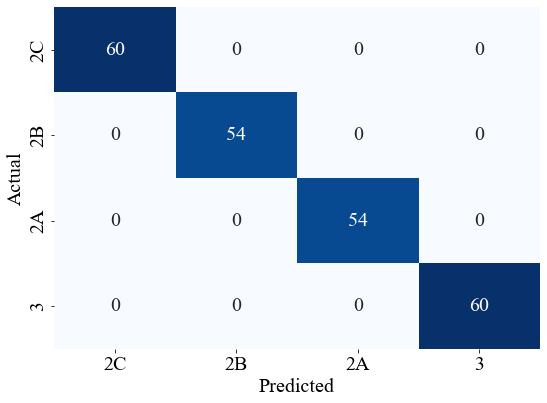

In [80]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


preds_heat = np.array(preds.cpu())
trues_heat = np.array(labels_true.cpu())
# preds_heat[0] = "3A"
# print(preds_heat)
# print(trues_heat)

heat = confusion_matrix(trues_heat, preds_heat)
# print(heat)

plt.rcParams["font.family"] = "Times New Roman"   # 使用するフォント
plt.rcParams["font.size"] = 20        

fig, ax = plt.subplots(figsize=(8, 6))
xtics = ["2C", "2B", "2A", "3"]
ytics = ["2C", "2B", "2A", "3"]
# Set the palette using the name of a palette:
sns.heatmap(heat, annot=True, xticklabels=xtics, yticklabels=ytics, cmap="Blues", cbar=False)
# sns.heatmap(heat, annot=True, cmap="Blues", cbar=False)
#*以下2行がポイント*  X,Y軸ラベルを追加
plt.xlabel("Predicted")
plt.ylabel("Actual")
#グラフをはみ出さないようにして画面に出力
plt.tight_layout()
fig.savefig("nn-heatmap_crossvalid.pdf")
plt.show()

In [ ]:
# サンプルごとに代償動作の度合いをセッティングしてみる
preds = np.array(outputs.cpu())
ans = np.array(labels_true.cpu())
plt.scatter(preds, ans)

In [ ]:
print(l_attention_weights[0].shape)

In [ ]:
index = 25

print(f"predicts are {preds[index]}, labels {labels_true[index]}")

RElbow2RWrist_weight = np.array(l_attention_weights[0].cpu()[index, 0, 1:]).reshape(1, -1)
RShoulder2RElbow_weight = np.array(l_attention_weights[1].cpu()[index, 0, 1:]).reshape(1, -1)
Pelvis2RShoulder_weight = np.array(l_attention_weights[2].cpu()[index, 0, 1:]).reshape(1, -1)
Pelvis2RNeck_weight = np.array(l_attention_weights[3].cpu()[index, 0, 1:]).reshape(1, -1)
Nect2RShoulder_weight = np.array(l_attention_weights[4].cpu()[index, 0, 1:]).reshape(1, -1)
Neck2LShoulder_weight = np.array(l_attention_weights[5].cpu()[index, 0, 1:]).reshape(1, -1)

weights = np.concatenate([RElbow2RWrist_weight, RShoulder2RElbow_weight, Pelvis2RShoulder_weight, Pelvis2RNeck_weight,
                         Nect2RShoulder_weight, Neck2LShoulder_weight])

fig, ax = plt.subplots(figsize=(20, 5))
# Set the palette using the name of a palette:
# sns.heatmap(RElbow2RWrist_weight, cmap='OrRd')
# sns.heatmap(RShoulder2RElbow_weight, cmap='OrRd')
# sns.heatmap(Pelvis2RShoulder_weight, cmap='OrRd')
# sns.heatmap(Pelvis2RNeck_weight, cmap='OrRd')
# sns.heatmap(Nect2RShoulder_weight, cmap='OrRd')
# sns.heatmap(Neck2LShoulder_weight, cmap='OrRd')

sns.heatmap(weights, cmap='OrRd')
plt.show()

In [ ]:
torch.__version__

In [ ]:
from matplotlib import gridspec

extract_data = np.array(X[19, 1:, 2]).flatten()
print(extract_data.shape)


time = np.linspace(0, 100, 100)
fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [6, 1]}, figsize=(15,10))
# Set the palette using the name of a palette:
sns.lineplot(time, extract_data, ax=ax[0])
sns.heatmap(extract_weight, cmap='OrRd', cbar=False, ax=ax[1])

plt.show()

In [ ]:
import seaborn as sns

data = np.array(attn_weights1[:, 0, :])
print(data.shape)
data = data.reshape(attn_weights1.shape[0], -1)

# print(outputs)
print(data.shape)

fig, ax = plt.subplots(figsize=(30, 20))
# Set the palette using the name of a palette:
sns.heatmap(data, cmap='OrRd')
plt.show()

In [ ]:
for i in range(len(data[0])):
    print(data[0,i], end=',')

In [ ]:
net_trained.net_Attention_1

In [ ]:
# modelの読み込みだけ
# 保存したモデルパラメータの読み込み
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net_trained = TransformerClassification().to(device)

net_trained.load_state_dict(torch.load('highacc2.pth'))
# print('読み込み後のモデル:\n', model2.state_dict())

In [ ]:
torch.save(net_trained.state_dict(), 'highacc3.pth')

# 新しいモデル
model2 = TransformerClassification().to(device)
print('新しいモデル:\n', model2.state_dict())

# 保存したモデルパラメータの読み込み
model2.load_state_dict(torch.load('highacc3.pth'))
print('読み込み後のモデル:\n', model2.state_dict())

# attention weight の保存

In [ ]:
data.shape
print(data)
print(data.reshape(-1))

In [ ]:
# 同時に入れるデータも作成する
# これは時系列スタンプ．0〜100がサンプル数だけ作られる
stamp_row = [i%data.shape[1] for i in range(data.shape[0] * data.shape[1])]

# いつ撮影されたのかのスタンプ
l_date_name = np.array(df_annotate['date'].unique())
date_row = []
for item in l_date_name:
    for i in range(data.shape[1]):
        date_row.append(item)
        
# アテンションウエイト
attn_weight = data.reshape(-1)

In [ ]:
df_attn = pd.DataFrame()
df_attn['date'] = date_row
df_attn["stamp"] = stamp_row
df_attn["attn_weight"] = attn_weight

In [ ]:
df_attn.to_excel('/Users/kento/kuhp/experiment/attention_weights.xlsx')

In [ ]:
type(df_attn['date'][0])